In [252]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

from scipy.special import expit
from collections import deque

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## References


### Forward mode & dual numbers

- https://en.wikipedia.org/wiki/Dual_number
- https://blog.demofox.org/2014/12/30/dual-numbers-automatic-differentiation/
- https://blog.demofox.org/2017/02/20/multivariable-dual-numbers-automatic-differentiation/
- https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6

### Backward mode & backpropagation

- https://www.jmlr.org/papers/volume18/17-468/17-468.pdf
- https://sidsite.com/posts/autodiff/
- https://github.com/karpathy/micrograd

In [815]:
class Tensor:
    def __init__(self, value):
        if isinstance(value, (int, float)):
            value = [value]

        self.value = np.array(value)
        
        self.grad = None
        self.children = []
        
    @property
    def leaf_node(self):
        return not bool(self.children)
        
    @property
    def shape(self):
        return self.value.shape
    
    @property
    def safe_grad(self):
        return self.zeros(self.shape) if self.grad is None else self.grad
    
    @staticmethod
    def check_input(value):
        if isinstance(value, (int, float)):
            return Tensor([value])
        elif isinstance(value, (list, np.ndarray)):
            return Tensor(value)
        return value
    
    # magick, тут я честно наоубом захуярил
    @staticmethod
    def unbroadcast(out, in_shape):
        sum_axis = None
        # Need to sum all axis with 1 = in_shape[i] < out.shape[i]
        if in_shape != (1,):
            sum_axis = tuple([i for i in range(len(in_shape)) if in_shape[i] == 1 and out.shape[i] > 1])

        return Tensor(out.value.sum(axis=sum_axis).reshape(in_shape))
    
    @staticmethod
    def ones(shape):
        return Tensor(np.ones(shape))
    
    @staticmethod
    def zeros(shape):
        return Tensor(np.zeros(shape))
        
    @staticmethod
    def uniform(shape):
        return Tensor(np.random.uniform(size=shape))
        
    @staticmethod
    def topsort(root):
        sort, visited = deque(), set()
        
        def dfs(node):
            for child in node.children:
                if child not in visited:
                    visited.add(child)
                    dfs(child)
            sort.appendleft(node)
        
        dfs(root)
        return sort
    
    def backward(self):
        topsort = self.topsort(self)
        self.grad = self.ones(self.shape)
        
        for root in topsort:
            if not root.leaf_node:
                out_grad = root._backward(root.grad.value)
                
                for i, child in enumerate(root.children):  
                    child.grad = child.safe_grad + out_grad[i]
                    child.grad = self.unbroadcast(child.grad, child.shape)
                    
    def reshape(self, *shapes):
        return Tensor(self.value.reshape(*shapes))
    
    def sum(self):
        node = Tensor(self.value.sum(axis=None))
        
        def _backward(din):
            return [din]
        
        node._backward = _backward
        node.children = [self]
        
        return node

    def norm(self):
        return np.linalg.norm(self.value)
    
    def sigmoid(self):
        exp = expit(self.value)
        
        node = Tensor(exp)
        
        def _backward(din):
            return [din * exp * (1 - exp)]
        
        node._backward = _backward
        node.children = [self]
        
        return node
    
    def relu(self):
        node = Tensor(np.maximum(0, self.value))
        
        def _backward(din):
            return [din * (self.value >= 0)]
        
        node._backward = _backward
        node.children = [self]
        
        return node
    
    def __matmul__(self, other):
        node = Tensor(self.value @ other.value)
        
        def _backward(din):
            return [din @ other.value.T, self.value.T @ din]
        
        node._backward = _backward
        node.children = [self, other]
        
        return node
    
    def __rmatmul__(self, other):
        pass
        
    def __add__(self, other):
        other = self.check_input(other)
        
        node = Tensor(self.value + other.value)
        
        def _backward(din):
            return [din, din]

        node._backward = _backward
        node.children = [self, other]
        
        return node
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __iadd__(self, other):
        other = self.check_input(other)
        self.value = self.value + other.value
        
        return self
    
    def __isub__(self, other):
        other = self.check_input(other)
        self.value = self.value - other.value
        
        return self
    
    def __mul__(self, other):
        other = self.check_input(other)
        
        node = Tensor(self.value * other.value)
        
        def _backward(din):
            return [din * other.value, din * self.value]

        node._backward = _backward
        node.children = [self, other]
        
        return node

    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        
        node = Tensor(self.value ** other)
        
        def _backward(din):
            return [din * (other * self.value ** (other - 1))]
        
        node._backward = _backward
        node.children = [self]
        
        return node
    
    def __neg__(self):
        return self * -1
    
    def __repr__(self):
        array_repr = ",\n".join([7*" " + str(line) if i > 0 else str(line) for i, line in enumerate(self.value)])
                
        return f"Tensor({array_repr})"

In [549]:
x_ = np.random.uniform(size=(2, 3))
y_ = np.random.uniform(size=(2, 3))

In [550]:
x = torch.tensor(x_, requires_grad=True)
y = torch.tensor(y_, requires_grad=True)
z = torch.sum((x - y)**2)

z.backward(torch.ones_like(z))

In [551]:
x.grad

tensor([[ 0.4898,  0.7357,  0.0955],
        [ 1.3376, -0.1113,  0.1987]], dtype=torch.float64)

In [684]:
mx = Tensor(x_)
my = Tensor(y_)
mz = ((mx - my)**2).sum()

mz.backward()

In [685]:
mx.grad

Tensor([0.48984973 0.73570217 0.09549759],
       [ 1.33759629 -0.11125404  0.19871018])

# Optimization test

TODO: check grads with torch!

In [771]:
import matplotlib.pyplot as plt

In [807]:
class Linear:
    def __init__(self, in_shape, out_shape):
        self.W = Tensor.uniform((in_shape, out_shape))
        self.b = Tensor.uniform((1, out_shape))
        
    def __call__(self, X):
        return (X @ self.W) + self.b


class SimpleRegNet:
    def __init__(self, in_shape):
        self.l1 = Linear(in_shape, 32) 
        self.l2 = Linear(32, 32)
        self.l3 = Linear(32, 1)
        
    def parameters(self):
        return [self.l1.W, self.l1.b, self.l2.W, self.l2.b, self.l3.W, self.l3.b]
        
    def zero_grad(self):
        for param in self.parameters():
            param.grad = None
            
    def __call__(self, X):
        x = self.l1(X)
        x = self.l2(x)
        
        return self.l3(x)

def mse(y_pred, y_true):
    return ((y_pred - y_true)**2).sum() * (1 / y_true.shape[0])

In [836]:
from sklearn.datasets import make_regression

X_, y_ = make_regression(100, 1, bias=15.0, noise=20)
X, y = Tensor(X_), Tensor(y_).reshape(-1, 1)

In [837]:
net = SimpleRegNet(X.shape[1])
lr = 0.1

for i in range(50):
    net.zero_grad()
    
    loss = mse(net(X), y)
    loss.backward()
    
    for param in net.parameters():
        param -= lr * param.grad * (1 / param.grad.norm())

    print(loss.value[0])

28056.231660523223
23317.460627531527
19210.740269910475
15675.55940664438
12655.153428664888
10096.378293791548
7949.586483538012
6168.504919036088
4710.114806217724
3534.533317025505
2604.896865521048
1887.2453822940013
1350.4060872675568
965.8727641155995
707.6687641584429
552.1533953424004
459.8961726404722
406.2587842235396
383.8716818432483
378.85803893895167
383.97787381974183
378.60385714378623
383.6864430526381
378.41491533421424
383.46843437321564
378.27378557657175
383.30436486915977
378.16747069627877
383.17968214714864
378.0863747538793
383.0836133801105
378.0234706041244
383.00824419202104
377.97364640104877
382.94779774364974
377.93320384783226
382.89808064225565
377.8994794109223
382.85606327946465
377.8705620629433
382.81956575408105
377.84508508232705
382.78702509796915
377.8220737093269
382.75732414109643
377.80083439026066
382.72966653285636
377.7808746788641
382.7034859826199
377.76184555990477


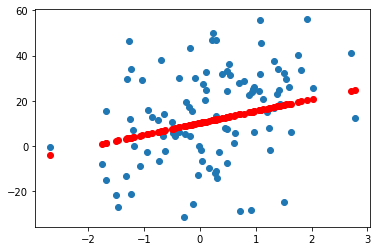

In [838]:
plt.scatter(X_, y_)
plt.scatter(X_, net(X).value, c="red") 

In [864]:
from sklearn.datasets import load_boston
from tqdm.notebook import tqdm

X_, y_ = load_boston()["data"], load_boston()["target"]
X, y = Tensor(X_), Tensor(y_).reshape(-1, 1)

In [866]:
net = SimpleRegNet(X.shape[1])
lr = 0.1

for i in tqdm(range(10_000)):
    net.zero_grad()
    
    loss = mse(net(X), y)
    loss.backward()
    
    for param in net.parameters():
        lr = lr / (1 + 2e-6 * i)
        
        param -= lr * param.grad * (1 / param.grad.norm())

print(loss.value[0])


54.54732220984849
